In [185]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import os

%matplotlib inline

batches.meta  data_batch_3  data.mat		test_signs.h5
data_batch_1  data_batch_4  test_batch		train_catvnoncat.h5
data_batch_2  data_batch_5  test_catvnoncat.h5	train_signs.h5


In [0]:
os.chdir('drive/My Drive/Dataset')

In [0]:
def Load_Data():
  
  train_dataset = h5py.File('train_signs.h5')
  train_set_X_orig = np.array(train_dataset['train_set_x'][:])
  train_set_Y_orig = np.array(train_dataset['train_set_y'][:])
  
  test_dataset = h5py.File('test_signs.h5')
  test_set_X_orig = np.array(test_dataset['test_set_x'][:])
  test_set_Y_orig = np.array(test_dataset['test_set_y'][:])
  
  classes = np.array(test_dataset['list_classes'][:])
  
  return train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes
  

In [0]:
def Data_Preprocessing():
  
  train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes = Load_Data()
  
  train_set_X = train_set_X_orig/255
  train_set_Y = train_set_Y_orig.reshape(train_set_Y_orig.shape[0],1)
  test_set_X = test_set_X_orig/255
  test_set_Y = test_set_Y_orig.reshape(test_set_Y_orig.shape[0],1)
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y

(1080, 64, 64, 3) (1080,)
(1080, 1)
(1080, 6)
Y = [5]. This is a sign of number [5]


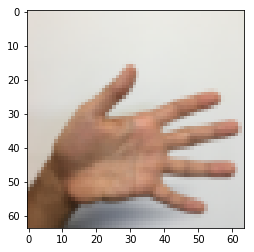

In [188]:
train_set_X,train_set_Y,test_set_X,test_set_Y,classes = Load_Data()
print(train_set_X.shape,train_set_Y.shape)
train_set_Y = train_set_Y.reshape(train_set_Y.shape[0],1)
print(train_set_Y.shape)
X = np.eye(6)[train_set_Y.T][0]
print(X.shape)
plt.imshow(train_set_X[0])
print('Y = '+str(train_set_Y[0])+'. This is a sign of number '+str(classes[train_set_Y[0]]))

In [0]:
def Create_Placeholder(train_set_X_shape,train_set_Y_shape):
  
  shape1 = train_set_X_shape
  shape2 = train_set_Y_shape
  
  X = tf.placeholder(name='X',dtype=tf.float32,shape=(None,shape1[1],shape1[2],shape1[3]))
  Y = tf.placeholder(name='Y',dtype=tf.float32,shape=(None,shape2[1]))
  
  return X,Y

In [0]:
def Initialize_Parameters(channels,filter_conv):
  
  L = len(channels)
  parameters = {}
  
  for l in range(1,L):
    W = tf.get_variable(name='WC'+str(l),shape=(filter_conv[l-1][0],filter_conv[l-1][1],channels[l-1],channels[l]),initializer=tf.contrib.layers.xavier_initializer())
    parameters['WC'+str(l)] = W
  
  return parameters

In [0]:
tf.reset_default_graph()

In [0]:
def Forward_Propagation(train_set_X,parameters,layers_dims,filter_pool,stride_conv,stride_pool,padding):
  
  L = len(stride_conv)
  AC = tf.convert_to_tensor(train_set_X,dtype=tf.float32)
  
  for l in range(L):
    W = parameters['WC'+str(l+1)]
    s = stride_conv[l]
    p = padding[l]
    ZC = tf.nn.conv2d(AC,W,strides=[1,s[0],s[1],1],padding=[[0,0],p,p,[0,0]])
    ZCNorm = tf.layers.batch_normalization(ZC,axis=-1,epsilon=0.0001,center=True,scale=True,gamma_initializer=tf.contrib.layers.xavier_initializer(),beta_initializer=tf.zeros_initializer())
    AC = tf.nn.relu(ZCNorm)
    if(l%2 == 1):
      f = filter_pool[int(l/2)]
      sp = stride_pool[int(l/2)]
      AC = tf.nn.max_pool(AC,ksize=[1,f[0],f[1],1],strides=[1,sp[0],sp[1],1],padding='VALID')
   
  AF = tf.contrib.layers.flatten(AC)
  L = len(layers_dims)
  
  for l in range(L):
    ZF = tf.contrib.layers.fully_connected(AF,layers_dims[l],activation_fn=None)
    ZFNorm = tf.layers.batch_normalization(ZF,axis=-1,epsilon=0.0001,center=True,scale=True,gamma_initializer=tf.contrib.layers.xavier_initializer(),beta_initializer=tf.zeros_initializer())
    if(l != L-1):
      AF = tf.nn.relu(ZFNorm)
    else:
      AF = ZFNorm
  
  return AF

In [0]:
def compute_cost_sigmoid(Y,A,parameters,regu,lambd,channels):
  
  m_train = Y.shape[0]
  cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=A,labels=Y))
  
  if(regu):
    sum = tf.Variable(0.0)
    L = len(channels)
    
    for l in range(1,L):
      WC = parameters['WC'+str(l)]
      sum = tf.add(sum,tf.l2_loss(WC))
      
    sum = tf.divide(sum,m_train)
    cost = tf.add(sum,cost)
  
  return cost

In [0]:
def compute_cost_softmax(Y,A,parameters,regu,lambd,channels):
  
  m_train = Y.shape[0]
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=A,labels=Y))
  
  if(regu):
    sum = tf.Variable(0.0)
    L = len(channels)
    
    for l in range(1,L):
      WC = parameters['WC'+str(l)]
      sum = tf.add(sum,tf.l2_loss(WC))
      
    sum = tf.divide(sum,m_train)
    cost = tf.add(sum,cost)
   
  return cost

In [0]:
def Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size):
  
  m_train = train_set_X.shape[0]
  perm = list(np.random.permutation(m_train))
  train_set_X = train_set_X[perm,:,:,:]
  train_set_Y = train_set_Y[perm,:]
  
  n = int(m_train/mini_batch_size)
  minibatches = []
  
  for i in range(n):
    X = train_set_X[i*mini_batch_size:(i+1)*mini_batch_size,:,:,:]
    Y = train_set_Y[i*mini_batch_size:(i+1)*mini_batch_size,:]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  if(m_train % mini_batch_size != 0):
    X = train_set_X[n*mini_batch_size:m_train,:,:,:]
    Y = train_set_Y[n*mini_batch_size:m_train,:]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  return minibatches

In [0]:
def Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,layers_dims,channels,filter_conv,filter_pool,stride_conv,stride_pool,padding):
  
  lambd = 0.1
  regu = False
  mini_batch_size = 64
  L = len(layers_dims)
  
  if(layers_dims[L-1] > 1):
    train_set_Y = np.eye(6)[train_set_Y.T][0]
    test_set_Y = np.eye(6)[test_set_Y.T][0]
    activation = 'softmax'
  else:
    activation = 'sigmoid'
    
  total_cost = []
  X,Y = Create_Placeholder(train_set_X.shape,train_set_Y.shape)
  parameters = Initialize_Parameters(channels,filter_conv)
  A = Forward_Propagation(X,parameters,layers_dims,filter_pool,stride_conv,stride_pool,padding)
  
  if(activation == 'softmax'):
    cost = compute_cost_softmax(Y,A,parameters,regu,lambd,channels)
  else:
    cost = compute_cost_sigmoid(Y,A,parameters,regu,lambd,channels)
  
  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
  
  init = tf.global_variables_initializer()
  sess = tf.Session()
  init = sess.run(init)

  for i in range(epochs):
    minibatches = Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size)

    for minibatch in minibatches:
      (minibatch_X,minibatch_Y) = minibatch

      val1,val2 = sess.run([cost,optimizer],feed_dict={X:minibatch_X,Y:minibatch_Y})

      if(True):
        total_cost.append(val1)
        
    print('Cost after '+str(i)+'th Iteration : '+str(val1))
  
  plt.plot(total_cost)
  plt.xlabel('Iterations')
  plt.ylabel('Cost')
  plt.title("Learning_Rate : "+str(learning_rate))
  plt.show()  
  
  if(activation == 'sigmoid'):
    A_val = tf.sigmoid(A)
    Acc = tf.reduce_mean(tf.multiply(A_val,Y))*100
    
  elif(activation == 'softmax'):
    Z = tf.nn.softmax(A)
    A_val = tf.argmax(Z,axis=1)
    A_corr = tf.equal(A_val,tf.argmax(Y,axis=1))
    Acc = tf.reduce_mean(tf.cast(A_corr,'float'))*100

    print("Training Set Accuracy  :  ",sess.run(Acc,feed_dict={X:train_set_X,Y:train_set_Y})) 
    print("Test Set Accuracy  :  ",sess.run(Acc,feed_dict={X:test_set_X,Y:test_set_Y}))
  
  parameters = sess.run(parameters)
  
  sess.close()
  
  return parameters

In [0]:
def Caller_Function():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y = Data_Preprocessing()
  learning_rate = 0.009
  epochs = 20
  channels = [train_set_X.shape[3]]
  channels.extend([32,64])
  filter_conv = [(3,3),(3,3)]
  filter_pool = [(2,2)]
  stride_conv = [(1,1),(1,1)]
  stride_pool = [(2,2)]
  padding = [[0,0],[0,0]]
  layers_dims=[1024,6]
  
  parameters = Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,layers_dims,channels,filter_conv,filter_pool,stride_conv,stride_pool,padding)
  
  print('')
  for key,value in parameters.items():
    print(key,value)

In [0]:
tf.reset_default_graph()
Caller_Function()